# Deep Learning and Generative Models project
### Andrea Adorni

# Objective
The aim of this project is to train and test a object detection model using an architecture like Faster R-CNN. The dataset is AITOD, a large dataset of images with annotations of different objects. In the beginning, this dataset was not available and for a while it has been replaced with another one (SkyFusion) but, in the end, one of the authors provided a link to download the dataset and, considering that early results in Skyfusion were not satisfying, I switched to AITOD. The dataset is composed of 11.214 images in training, 2.804 in validation and 14.018 in test. The bounding boxes and labels are annotated in a single json file for each partition in COCO format. 

# Dataset
Just looking at a few images, it’s obvious that the task is not just object detection, but it’s a small objects type. This kind of task seems to be pretty challenging by looking to literature.
There are 8 classes + background:
- airplane
- bridge
- storage-tank
- ship
- swimming-pool
- vehicle
- person
- wind-mill

We can see from the distribution how vehicles are the most numerous while wind-mills are the least numerous


{'vehicle': 265194, 'ship': 14074, 'airplane': 666, 'person': 14446, 'storage-tank': 5584, 'swimming-pool': 787, 'bridge': 603, 'wind-mill': 180}


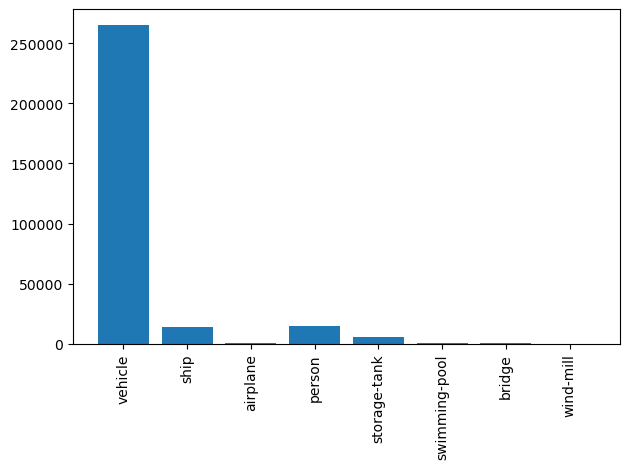

In [3]:

from funcs import get_count_per_class,CLASSES_MAP, get_datavis_transform
import random
import matplotlib.pyplot as plt
import json
import numpy as np
from aitod import AITOD
from torch.utils.tensorboard import SummaryWriter
train_data=AITOD('aitod/train',transform=get_datavis_transform())
summary_writer = SummaryWriter(log_dir='logs/datavisualization')
# get class distribution
data=json.load(open('aitod/train/annotations.json'))
count=get_count_per_class(data)
print(count)
fig, ax = plt.subplots()
plt.bar(count.keys(),count.values())
plt.xticks(rotation=90)
fig.tight_layout()
plt.show()
summary_writer.add_figure('class distribution', fig)

Following some sample images from training, which can also be viewed on tensorboard:

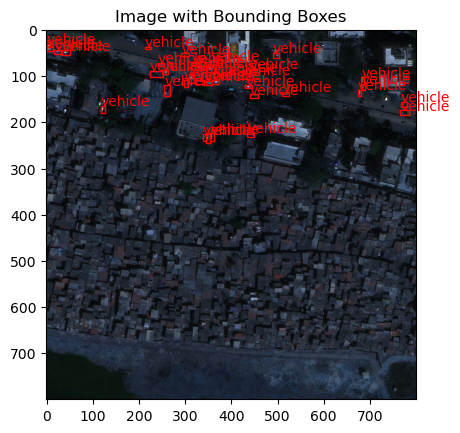

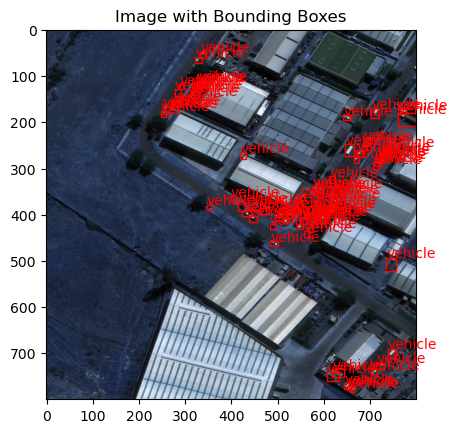

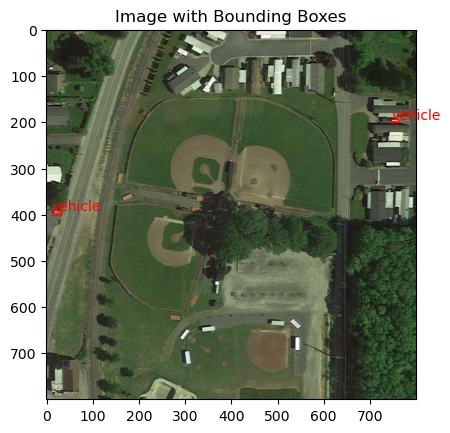

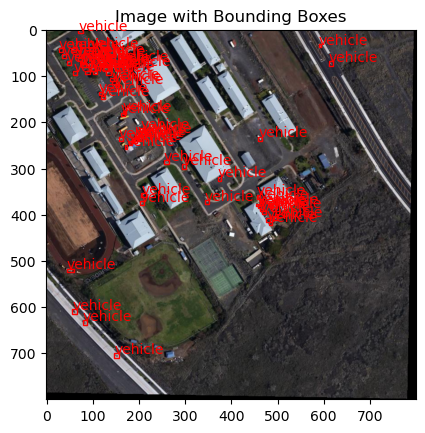

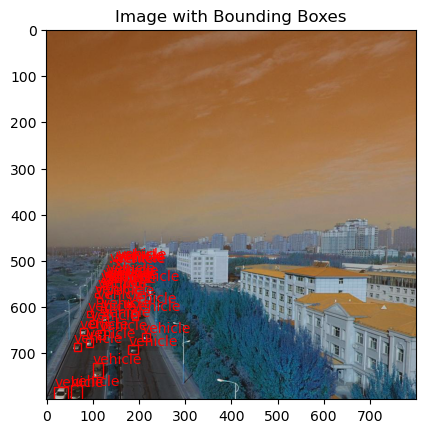

In [18]:
from PIL import Image
import matplotlib.patches as patches
from funcs import CLASSES
def show_image_with_bbox(image, boxes, labels):
    if type(image)==str:
        image = Image.open(image)
    fig, ax = plt.subplots()
    ax.imshow(image)
    for i in range(len(boxes)):
        box = boxes[i]
        label = labels[i]
        rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        plt.text(box[0],box[1],CLASSES[label],color='red')
        
    plt.title('Image with Bounding Boxes')
    return fig
# get random image
for im in range(5):
    image, target = train_data[random.randint(0, len(train_data)-1)]
    # visualize the image
    
    img=show_image_with_bbox(f"aitod/train/images/{target['image_name']}", target['boxes'], target['labels'])
    plt.show()
    l=[CLASSES_MAP[str(label.item())] for label in target['labels']]
    summary_writer.add_image_with_boxes('training sample', image, target['boxes'], labels=l, global_step=im)

# Implementation
The first thing developed is the custom pytorch Dataset in `aitod.py`. Basically, it gets every image from the folder (we have a single dataset object for Training, a single one for validation and so on) and extracts the annotations from the json file and transform the images and the bounding boxes according to Pytorch’s Faster R-CNN model’s requirements with a random horizontal flip for data augmentation in training.

Then, a solver was built in `model.py` in order to train the network on the training set, giving some params and the Dataloaders
This solver basically does the following:
-	Loads all the params in input like: dataloaders, optimizer, model type, scheduler, max epochs and so on.
-	If there is a epoch to load and it’s not a fresh start, it loads the weights using its uuid.
-	Creates a Early Stopping handler from `earlystopping.py` that stores the best validation loss.
-	Trains the model and validate through epochs.
-	Saves state after every epoch.
-	Log losses and gradient hists inside Tensorboard
Basically, there are three types of model with their builder in `funcs.py`:
-	Faster R-CNN, ResNet50 backbone with FPN (pretrained and not pretrained versions) 
-	RetinaNet, ResNet50 backbone with FPN (pretrained)
-	Faster R-CNN, ResNet50 backbone with FPN but with a custom and smaller Anchor Generator (pretrained and not pretrained)
For a easier training, everything is set in a configuration file that the main file run.py reads before running the task.

The pipeline:
-	In `run.py`, you can choose which of the three models you want to train and then the code gets the parameters from `config.py`. To identify the single run, it generates a id and gets the current timestamp
-	It creates a solver from `model.py` and starts the training phase.
-	The solver trains from training set and get the losses from the validation set after each epoch, then saves the weights
-	When the losses stop decreasing after 5 epochs it stops the process and saves the best weights in the last epoch.
-	evaluate.py gets the last epoch weights (the best one according to Early stopping, because none of them reached 100 epochs during training) and evaluates the model doing the inference on the test set and saving in a csv file the results of Mean Average Precision (mAP) and Mean Average Recall (mAR)

Each run has a combination of two identifiers, a uuid and the timestamp. Both are used to identify the run and the weights.


Grey is 'retinanet_resnet' pretrained

Light blue is 'faster_rcnn_resnet' pretrained

Magenta is custom_RPN_faster_rcnn_resnet not pretrained

Yellow is custom_RPN_faster_rcnn_resnet pretrained

Purple is 'faster_rcnn_resnet' not pretrained

![Loss train](losstrain.png "Training losses")
![lossval](lossval.png "Validation losses")

# Results
Despite in the code `run.py` there is the possibility to use them, the results do not involve the optimizer Adam and the scheduler StepLR because during first training tests there was evidence that models were not learning due to losses not decreasing. StepLR also could trigger a learning rate decrease when it’s not necessary. So the optimizer and scheduler used in the results are SGD and ReduceLROnPlateu. Finally, a library was used that provides several techniques to improve the detection of small objects, from the paper [Slicing Aided Hyper Inference and Fine-Tuning for Small Object Detection](https://ieeexplore.ieee.org/document/9897990). For reasons of resources and time, only the technique involving sliced inference was tried.

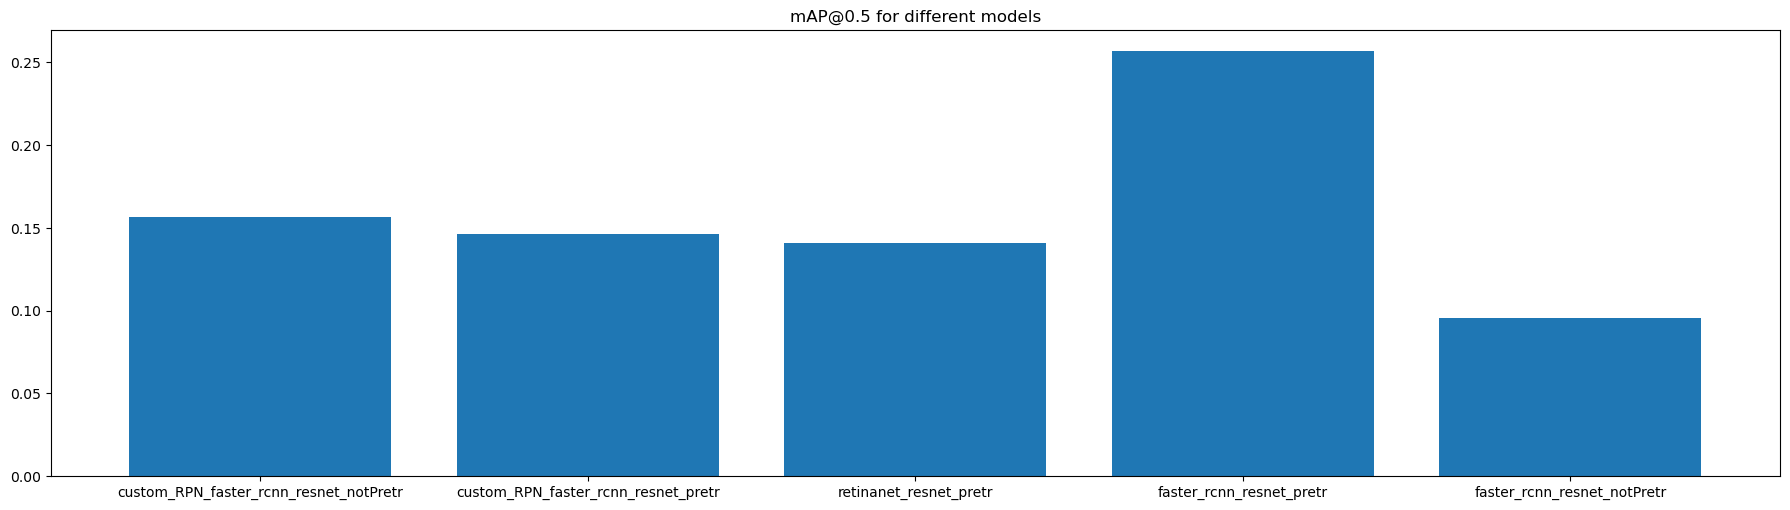

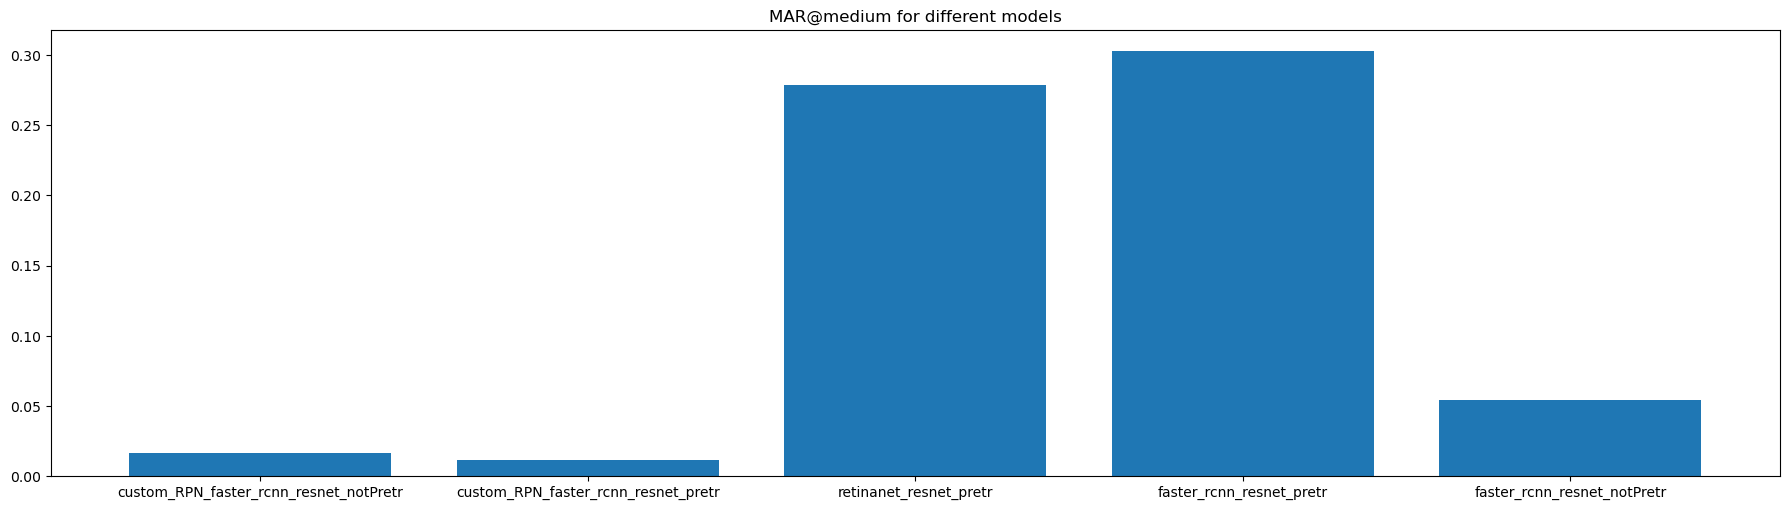

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
df=pd.read_csv('results.csv', sep=',')
df['pretrained']=df['model_params'].apply(lambda x: eval(x)['pretrained'])
df['modelidentifier']=df['model']+'_'+df['pretrained'].apply(lambda x: 'pretr' if x else 'notPretr')
fig, ax = plt.subplots(figsize=(18, 5))
plt.bar(df['modelidentifier'],df['map_50'])
fig.tight_layout()
plt.title('mAP@0.5 for different models')
plt.show()
summary_writer.add_figure('mAP@0.5', fig)

#mar_medium
fig, ax = plt.subplots(figsize=(18, 5))
plt.bar(df['modelidentifier'],df['mar_medium'])
fig.tight_layout()
plt.title('MAR@medium for different models')
plt.show()
summary_writer.add_figure('MAR@medium', fig)


According to the results, the best model is the Faster R-CNN with ResNet50 backbone and FPN with default Anchor Generator and pretrained. Probably in the pretrained version there is a local minimum better reachable than the not pretrained one and using a smaller sized anchor generator isn't the best solution to improve results in this dataset. The model was trained for 100 epochs but the early stopping stopped before reaching the end.

Let's try to do some inference on test set with sliced inference in `evaluatesahi.py` and see the results on Mean Average Precision and Recall. Basically it splits the image of 800x800 in 4 parts of 512x512 with an overlapping of 0.2 and then it does the inference on each part and merges the results. The results are saved in a txt file.

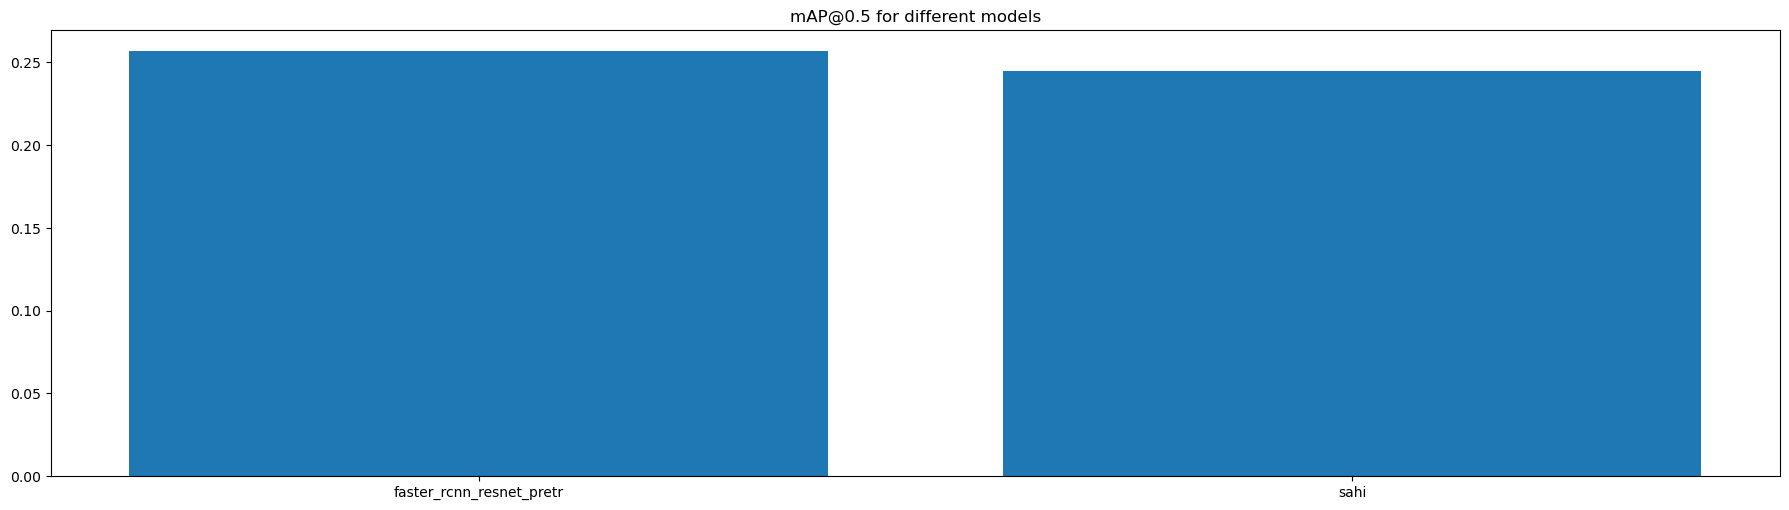

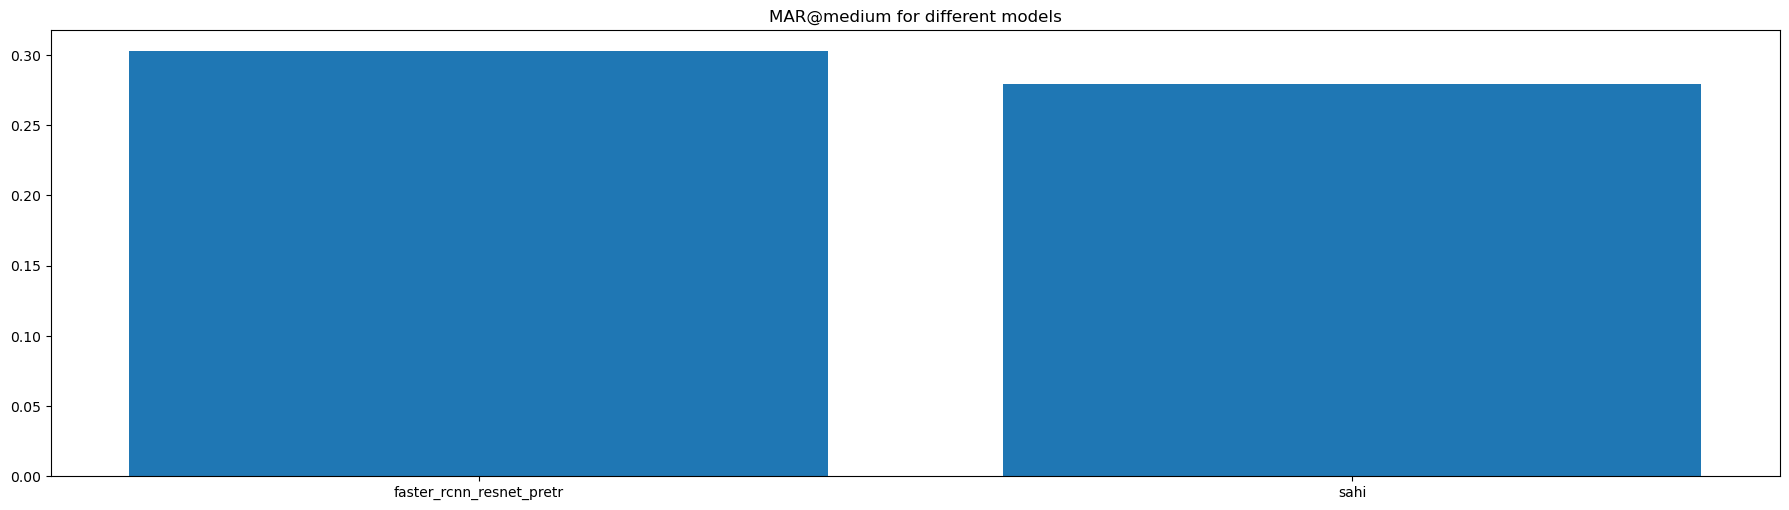

In [10]:
dfbest=df[df['mar_medium']==df['mar_medium'].max()]
dictmodel={}
fig, ax = plt.subplots(figsize=(18, 5))
with open('resultsSahi.txt','r') as f:
    dictmodel=f.read()
    dictmodel=eval(dictmodel)
    dictmodel.pop('classes')
    dictmodel['modelidentifier']='sahi'
dfsahi=pd.DataFrame([dictmodel])
dfbest=pd.concat([dfbest,dfsahi])
plt.bar(dfbest['modelidentifier'],dfbest['map_50'])
fig.tight_layout()
plt.title('mAP@0.5 for different models')
plt.show()
summary_writer.add_figure('mAP@0.5 with sahi', fig)

#mar_medium
fig, ax = plt.subplots(figsize=(18, 5))
plt.bar(dfbest['modelidentifier'],dfbest['mar_medium'])
fig.tight_layout()
plt.title('MAR@medium for different models')
plt.show()
summary_writer.add_figure('mAR@medium with sahi', fig)


So basically, Sahi didn't improve the results, this can be due to differente reasons like the fact that the images are already small and the objects are small too, or the fact that the model is already pretrained and the sliced inference is not useful in this case. There is another technique that can be tried: training the model with also sliced images, but this would require a lot of resources and time.

Let's plot some examples of inference on test set from `plotresults.py`:

Inference 1:

![Inference 1](testsample.png "Inference 1")

Inference 1 Target:

![Inference 1 Target](testsampletarget.png "Inference 1 Target")

Other inferences can be found in tensorboard.

In conclusion this task is more challenging than expected, the dataset is not easy to work with and the results are not satisfying to me. I think that with more time and resources, it would be possible to improve the results by trying different techniques and models, but for now this is the best I could do.